# 0. Introduction

### This document shows the performance of reanalysis before and after merging using a two-layer cross-validation.

### The merging weight is calculated using Bayesian Model Averaging (BMA).  
The input reanalysis data are after GWR-based downscaling and QM-based correction.

### Brief conclusions:  
(1) The performance: BMA merging > ERA5 > MERRA2 > JRA55.  
(2) The merging weight of ERA5 is the largest, but the overall, weights of the three reanalysis datasets are comparable without too large differences because the actual acurracy of the three datasets are generally comparable.  
(3) Although we can see BMA shows better performance than all the three datasets, only using ERA5 also seems acceptable which will (1) result in a decrease in accuracy, but (2) simplify the framework of EMDNA.  

# 1. Load modules and files

In [19]:
import numpy as np
import auxiliary as au
import pandas
from matplotlib import pyplot as plt
import tabulate

def cal_statiscs(file_stn, file_reamerge, var):
    # load station data
    d1=np.load(file_stn)
    stn_lle=d1['stn_lle']
    stndata=d1[var+'_stn']
    stndata[np.nanmean(stndata,axis=1)==0,:]=np.nan
    nstn,ntimes=np.shape(stndata)
    reanum = 4
    
    # load downscaled data
    downdata=np.nan*np.zeros([reanum,nstn,ntimes], dtype=np.float32)
    d2=np.load(file_reamerge)
    downdata[0:3]=d2['reacorr_stn']
    downdata[3]=d2['reamerge_stn']
    
    # calculate the metrics for each station
    met_prcp=np.nan * np.zeros([reanum,nstn,4])
    for i in range(nstn):
        if np.isnan(stndata[i,0]):
            continue
        for r in range(reanum):
            met_prcp[r,i,:] = au.metric(stndata[i],downdata[r,i,:])

    mean_prcp = np.zeros([nstn,reanum+1])
    mean_prcp[:,0] = np.nanmean(stndata, axis=1)
    for i in range(reanum):
        mean_prcp[:,i+1]=np.nanmean(downdata[i], axis=1)
    return met_prcp, mean_prcp

file_stn='/Users/localuser/Research/EMDNA/stndata_whole.npz'
# file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_prcp_nearestQM_BMA.npz'
file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_prcp_GWRQM_BMA.npz'
met_prcp, mean_prcp = cal_statiscs(file_stn, file_reamerge, 'prcp')

file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_tmean_GWRQM_BMA.npz'
met_tmean, mean_tmean = cal_statiscs(file_stn, file_reamerge, 'tmean')

file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_trange_GWRQM_BMA.npz'
met_trange, mean_trange = cal_statiscs(file_stn, file_reamerge, 'trange')

# lle
d1=np.load(file_stn)
stn_lle=d1['stn_lle']
del d1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/localuser/Github/PyGMET/auxiliary.py:150: RuntimeWarning: Mean of empty slice
  metout[1] = np.n

# 2. Spatial distribution of station and raw/corrected reanalysis data

## 2.1 Precipitation

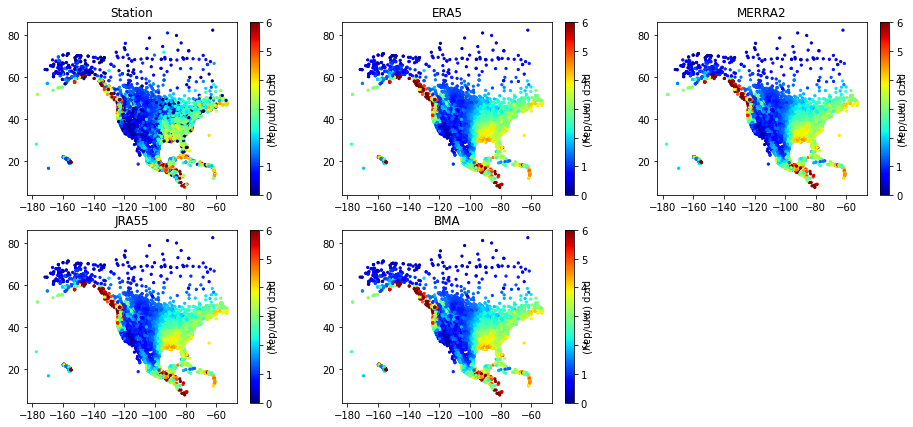

In [20]:
dplot = mean_prcp
titles=['Station','ERA5','MERRA2','JRA55','BMA']
plt.figure(figsize=[16,7])
for i in range(len(titles)):
    plt.subplot(2,3,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[:,i],cmap='jet')
    cbar = plt.colorbar()
    cbar.set_label('prcp (mm/day)', rotation=270)
    plt.clim([0,6])
    plt.title(titles[i])

## 2.2 Tmean

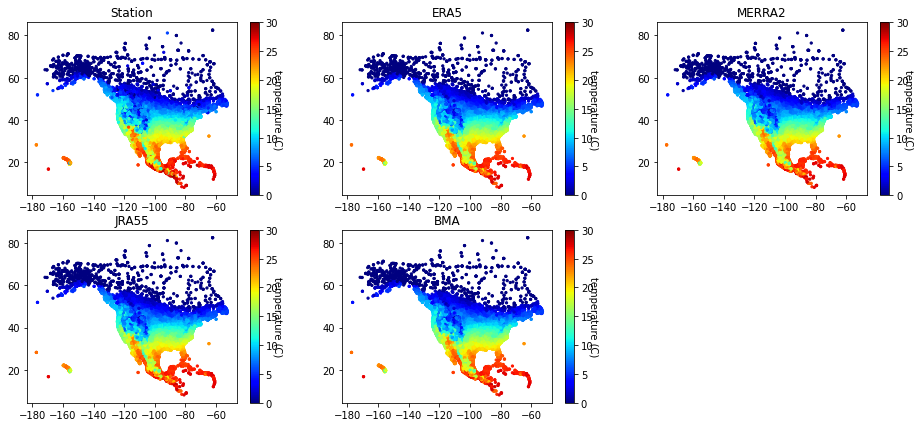

In [22]:
dplot = mean_tmean
titles=['Station','ERA5','MERRA2','JRA55','BMA']
plt.figure(figsize=[16,7])
for i in range(len(titles)):
    plt.subplot(2,3,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[:,i],cmap='jet')
    cbar = plt.colorbar()
    cbar.set_label('temperature (C)', rotation=270)
    plt.clim([-0,30])
    plt.title(titles[i])

## 2.3 Trange

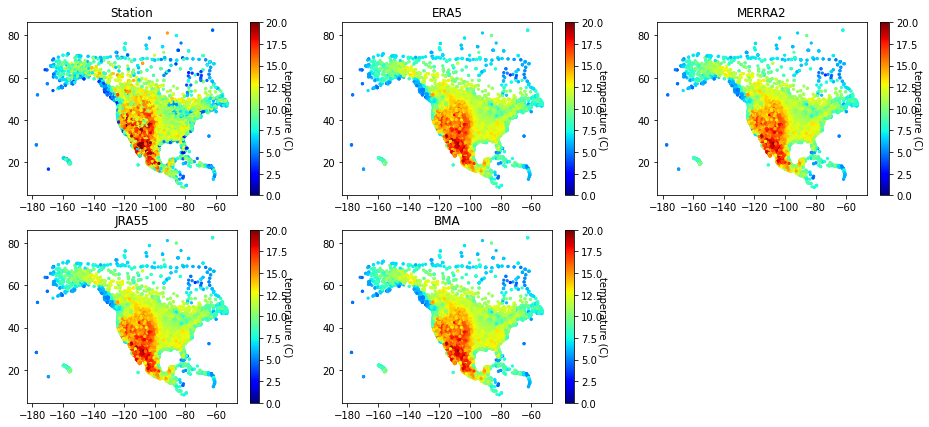

In [37]:
dplot = mean_trange
titles=['Station','ERA5','MERRA2','JRA55','BMA']
plt.figure(figsize=[16,7])
for i in range(len(titles)):
    plt.subplot(2,3,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[:,i],cmap='jet')
    cbar = plt.colorbar()
    cbar.set_label('temperature (C)', rotation=270)
    plt.clim([0,20])
    plt.title(titles[i])

# 3. Accuracy Evaluation

## Note: for this part, we should look more at distribution because the mean/median values are largely determined by stations in plain regions where the station number is very large

## 3.1 Precipitation

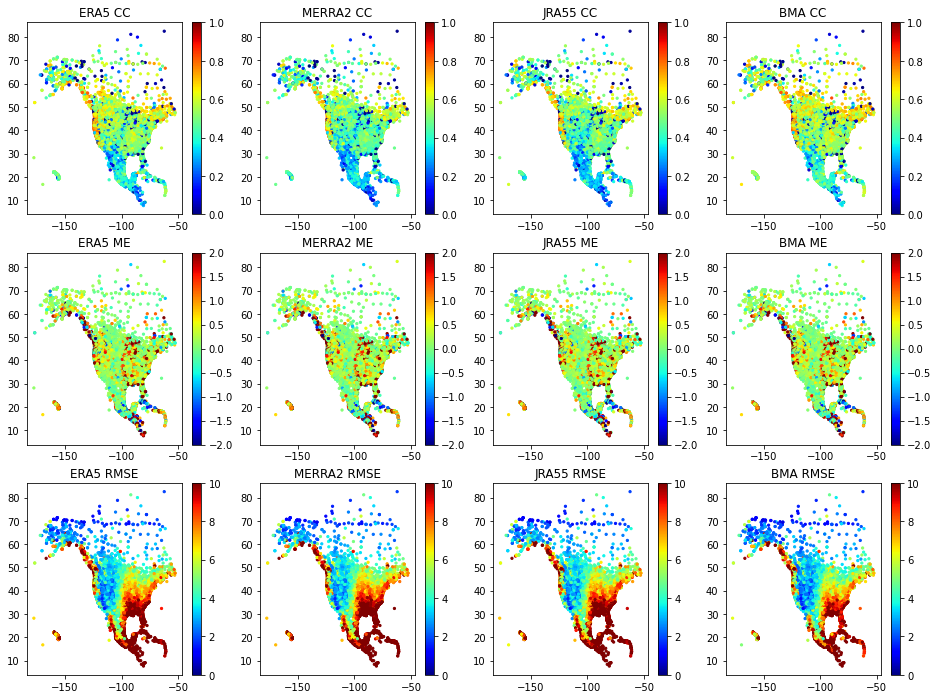

In [23]:
dplot=met_prcp
titles=['ERA5','MERRA2','JRA55','BMA']
plt.figure(figsize=[16,12])
for i in range(len(titles)):
    plt.subplot(3,4,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,0],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([0,1])
    plt.title(titles[i]+' CC')
    
    plt.subplot(3,4,i+5)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,1],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-2, 2])
    plt.title(titles[i]+' ME')
    
    plt.subplot(3,4,i+9)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,3],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([0,10])
    plt.title(titles[i]+' RMSE')

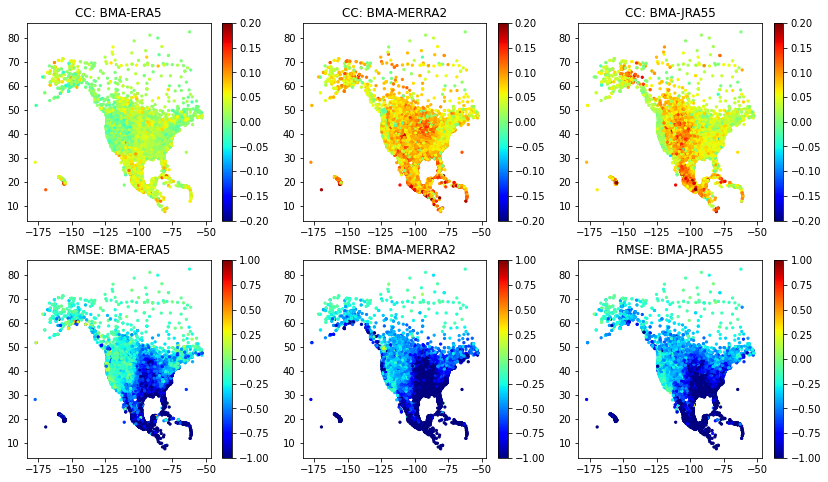

In [24]:
dplot=met_prcp
titles=['BMA-ERA5','BMA-MERRA2','BMA-JRA55']
plt.figure(figsize=[14,8])
for i in range(len(titles)):
    plt.subplot(2,3,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[3,:,0]-dplot[i,:,0],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-0.2,0.2])
    plt.title('CC: '+titles[i])
    
    plt.subplot(2,3,i+4)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[3,:,3]-dplot[i,:,3],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-1,1])
    plt.title('RMSE: '+titles[i])

In [25]:
metmean_prcp = np.zeros([4, 4])
for i in range(4):
    metmean_prcp[i] = np.nanmean(met_prcp[i,:,:],axis=0)
df = pandas.DataFrame(metmean_prcp,['ERA5','MERRA2','JRA55','BMA'],['CC', 'ME', 'MAE', 'RMSE'])
print('Mean metrics')
print(df.round(2))

print('##################################################')
print('##################################################')

metmedian_prcp = np.zeros([4, 4])
for i in range(4):
    metmedian_prcp[i] = np.nanmedian(met_prcp[i,:,:],axis=0)
df = pandas.DataFrame(metmedian_prcp,['ERA5','MERRA2','JRA55','BMA'],['CC', 'ME', 'MAE', 'RMSE'])
print('Median metrics')
print(df.round(2))

Mean metrics
          CC    ME   MAE  RMSE
ERA5    0.54  0.02  2.43  6.87
MERRA2  0.49  0.02  2.60  7.26
JRA55   0.50  0.02  2.59  7.13
BMA     0.57  0.02  2.35  6.30
##################################################
##################################################
Median metrics
          CC   ME   MAE  RMSE
ERA5    0.56 -0.0  2.36  6.73
MERRA2  0.49 -0.0  2.54  7.14
JRA55   0.51 -0.0  2.49  6.94
BMA     0.58 -0.0  2.27  6.16


## 3.2 Tmean

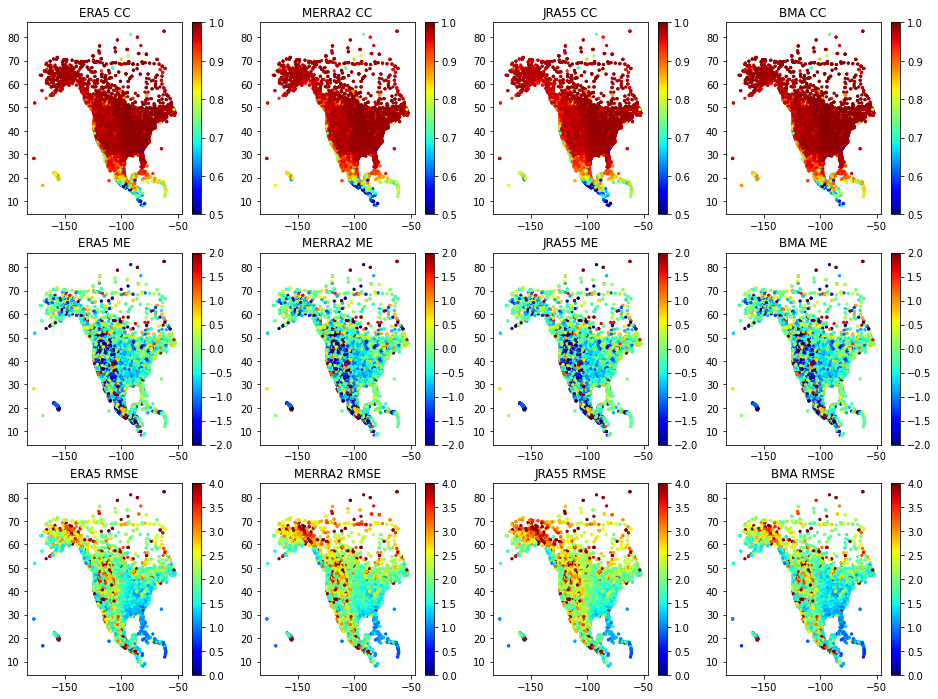

In [26]:
dplot=met_tmean
titles=['ERA5','MERRA2','JRA55','BMA']
plt.figure(figsize=[16,12])
for i in range(len(titles)):
    plt.subplot(3,4,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,0],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([0.5,1])
    plt.title(titles[i]+' CC')
    
    plt.subplot(3,4,i+5)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,1],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-2, 2])
    plt.title(titles[i]+' ME')
    
    plt.subplot(3,4,i+9)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,3],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([0,4])
    plt.title(titles[i]+' RMSE')

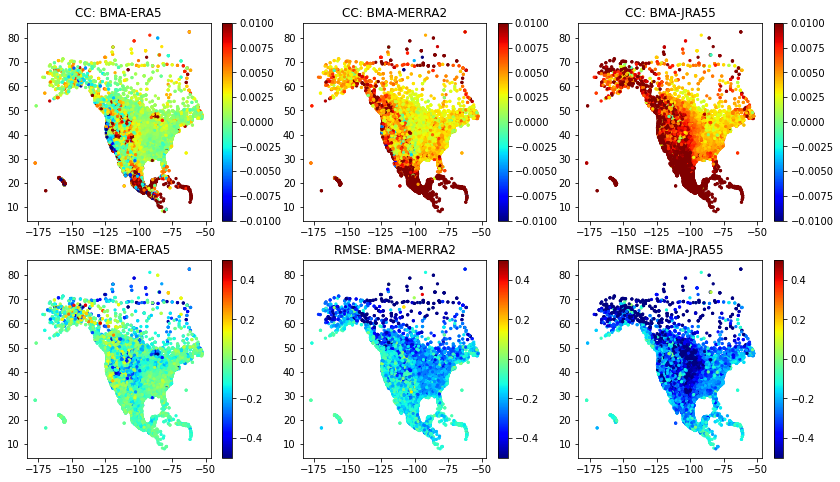

In [27]:
dplot=met_tmean
titles=['BMA-ERA5','BMA-MERRA2','BMA-JRA55']
plt.figure(figsize=[14,8])
for i in range(len(titles)):
    plt.subplot(2,3,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[3,:,0]-dplot[i,:,0],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-0.01,0.01])
    plt.title('CC: '+titles[i])
    
    plt.subplot(2,3,i+4)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[3,:,3]-dplot[i,:,3],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-0.5,0.5])
    plt.title('RMSE: '+titles[i])

In [28]:
metmean_tmean = np.zeros([4, 4])
for i in range(4):
    metmean_tmean[i] = np.nanmean(met_tmean[i,:,:],axis=0)
df = pandas.DataFrame(metmean_tmean,['ERA5','MERRA2','JRA55','BMA'],['CC', 'ME', 'MAE', 'RMSE'])
print('Mean metrics')
print(df.round(2))

print('##################################################')
print('##################################################')

metmedian_tmean = np.zeros([4, 4])
for i in range(4):
    metmedian_tmean[i] = np.nanmedian(met_tmean[i,:,:],axis=0)
df = pandas.DataFrame(metmedian_tmean,['ERA5','MERRA2','JRA55','BMA'],['CC', 'ME', 'MAE', 'RMSE'])
print('Median metrics')
print(df.round(2))

Mean metrics
          CC    ME   MAE  RMSE
ERA5    0.94 -0.01  1.73  2.21
MERRA2  0.94 -0.03  1.82  2.31
JRA55   0.94 -0.01  1.88  2.39
BMA     0.95 -0.01  1.69  2.14
##################################################
##################################################
Median metrics
          CC    ME   MAE  RMSE
ERA5    0.98 -0.03  1.54  2.04
MERRA2  0.97 -0.05  1.63  2.14
JRA55   0.97 -0.03  1.71  2.22
BMA     0.98 -0.03  1.49  1.96


## 3.3 Trange

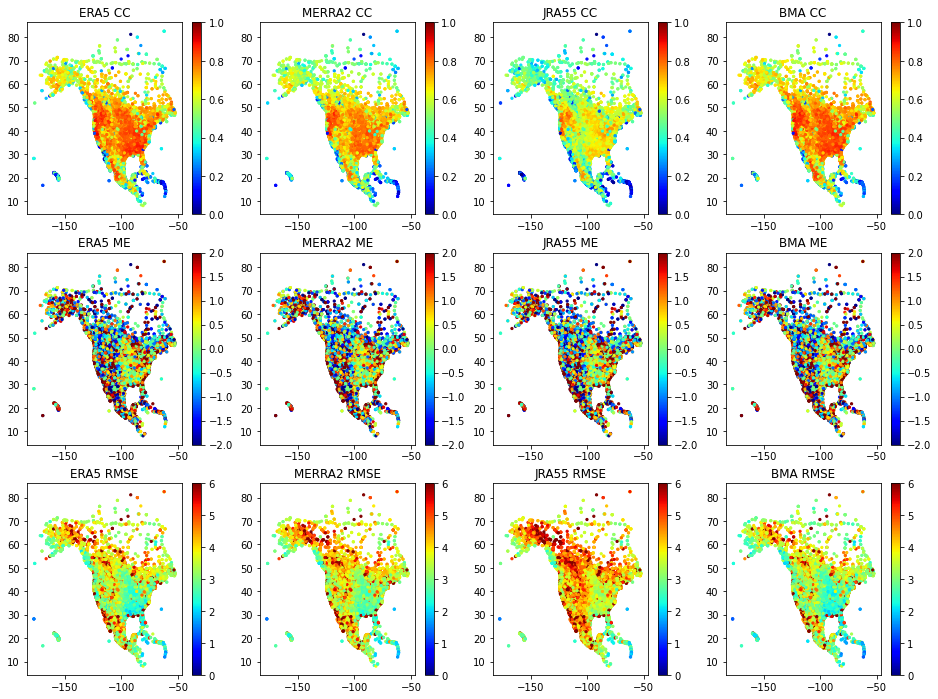

In [30]:
dplot=met_trange
titles=['ERA5','MERRA2','JRA55','BMA']
plt.figure(figsize=[16,12])
for i in range(len(titles)):
    plt.subplot(3,4,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,0],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([0,1])
    plt.title(titles[i]+' CC')
    
    plt.subplot(3,4,i+5)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,1],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-2, 2])
    plt.title(titles[i]+' ME')
    
    plt.subplot(3,4,i+9)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[i,:,3],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([0,6])
    plt.title(titles[i]+' RMSE')

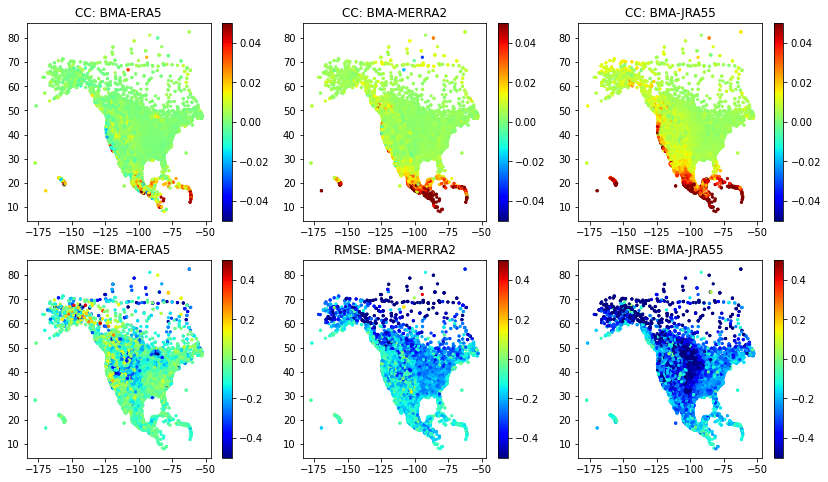

In [31]:
dplot=met_tmean
titles=['BMA-ERA5','BMA-MERRA2','BMA-JRA55']
plt.figure(figsize=[14,8])
for i in range(len(titles)):
    plt.subplot(2,3,i+1)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[3,:,0]-dplot[i,:,0],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-0.05,0.05])
    plt.title('CC: '+titles[i])
    
    plt.subplot(2,3,i+4)
    plt.scatter(stn_lle[:,1],stn_lle[:,0],5,dplot[3,:,3]-dplot[i,:,3],cmap='jet')
    cbar = plt.colorbar()
    plt.clim([-0.5,0.5])
    plt.title('RMSE: '+titles[i])

In [32]:
metmean_trange = np.zeros([4, 4])
for i in range(4):
    metmean_trange[i] = np.nanmean(met_trange[i,:,:],axis=0)
df = pandas.DataFrame(metmean_trange,['ERA5','MERRA2','JRA55','BMA'],['CC', 'ME', 'MAE', 'RMSE'])
print('Mean metrics')
print(df.round(2))

print('##################################################')
print('##################################################')

metmedian_trange = np.zeros([4, 4])
for i in range(4):
    metmedian_trange[i] = np.nanmedian(met_trange[i,:,:],axis=0)
df = pandas.DataFrame(metmedian_trange,['ERA5','MERRA2','JRA55','BMA'],['CC', 'ME', 'MAE', 'RMSE'])
print('Median metrics')
print(df.round(2))

Mean metrics
          CC   ME   MAE  RMSE
ERA5    0.67 -0.0  2.92  3.77
MERRA2  0.63 -0.0  3.08  3.95
JRA55   0.55 -0.0  3.41  4.38
BMA     0.68  0.0  2.82  3.63
##################################################
##################################################
Median metrics
          CC    ME   MAE  RMSE
ERA5    0.69 -0.05  2.80  3.67
MERRA2  0.66 -0.05  2.96  3.85
JRA55   0.56 -0.05  3.31  4.29
BMA     0.70 -0.05  2.68  3.52


# 4. BMA merging weights

## 4.1 Precipitation weight

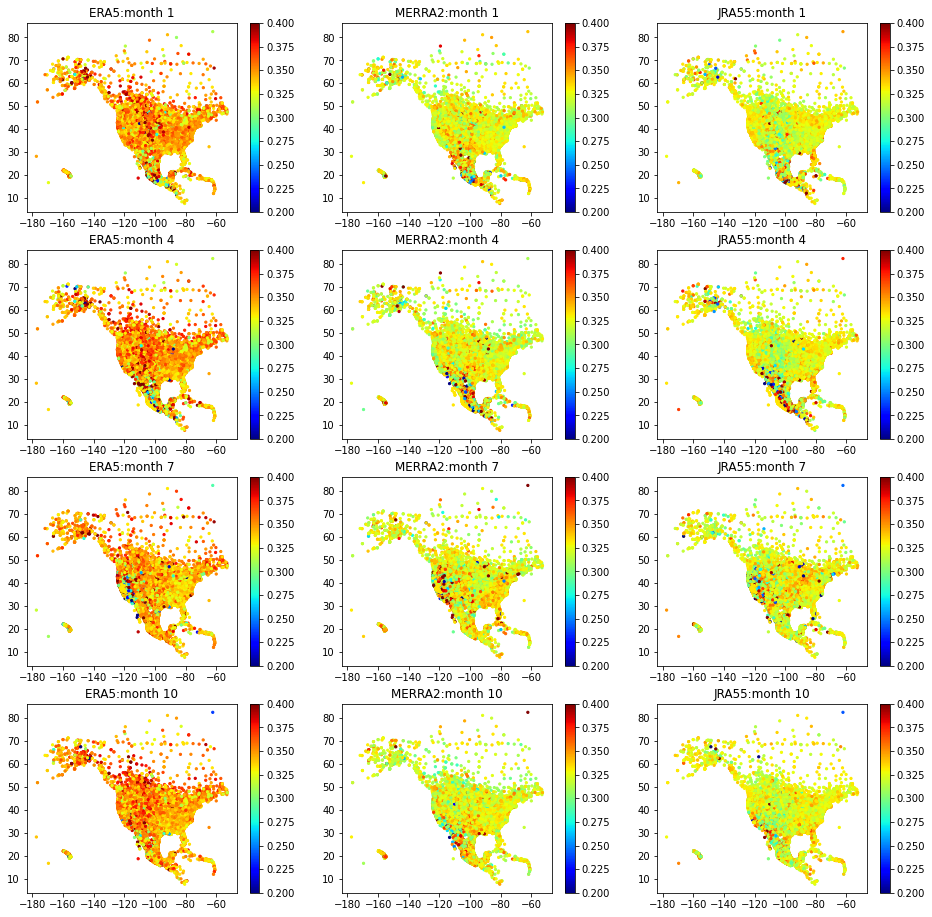

In [34]:
file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_prcp_GWRQM_BMA.npz'
d=np.load(file_reamerge)
reamerge_weight_stn=d['reamerge_weight_stn']

reaname=['ERA5','MERRA2','JRA55']
plt.figure(figsize=[16,16])
flag=1
for m in [0,3,6,9]:
    for i in range(3):
        plt.subplot(4,3,flag)
        plt.scatter(stn_lle[:,1],stn_lle[:,0],5,reamerge_weight_stn[m,:,i],cmap='jet')
        cbar = plt.colorbar()
        plt.clim([0.2,0.4])
        plt.title(reaname[i]+':month '+str(m+1))
        flag=flag+1

## 4.2 Tmean weight

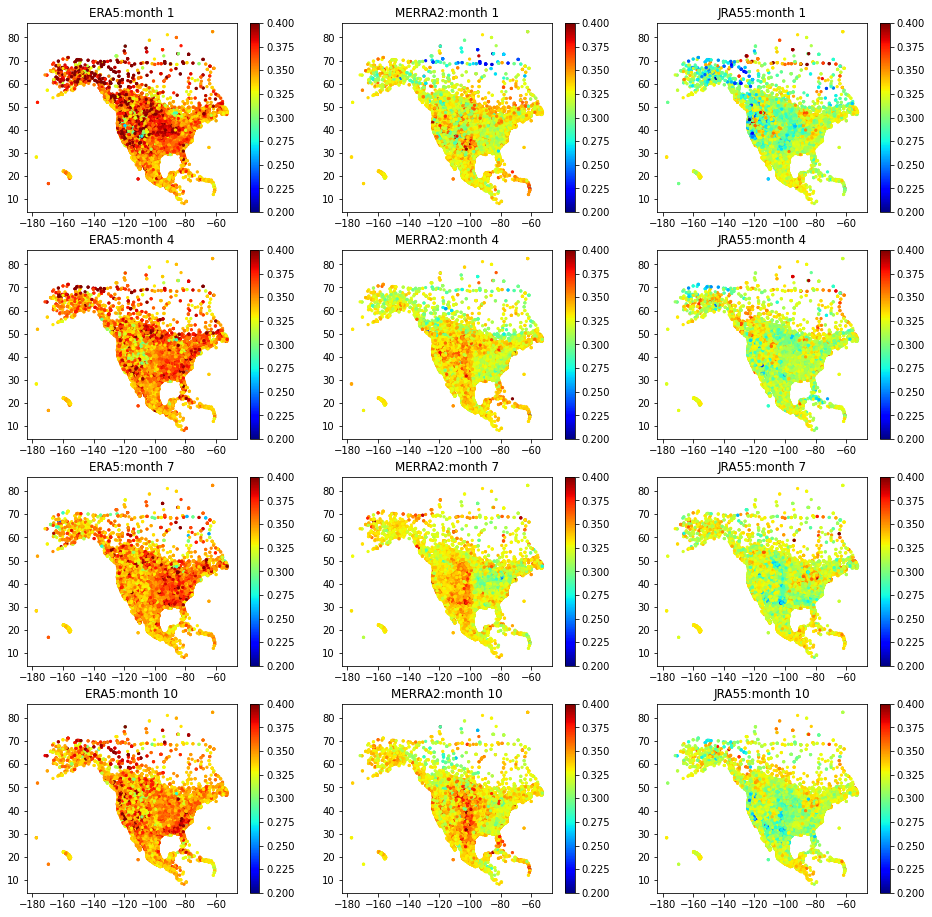

In [35]:
file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_tmean_GWRQM_BMA.npz'
d=np.load(file_reamerge)
reamerge_weight_stn=d['reamerge_weight_stn']

reaname=['ERA5','MERRA2','JRA55']
plt.figure(figsize=[16,16])
flag=1
for m in [0,3,6,9]:
    for i in range(3):
        plt.subplot(4,3,flag)
        plt.scatter(stn_lle[:,1],stn_lle[:,0],5,reamerge_weight_stn[m,:,i],cmap='jet')
        cbar = plt.colorbar()
        plt.clim([0.2,0.4])
        plt.title(reaname[i]+':month '+str(m+1))
        flag=flag+1

## 4.3 Trange weight

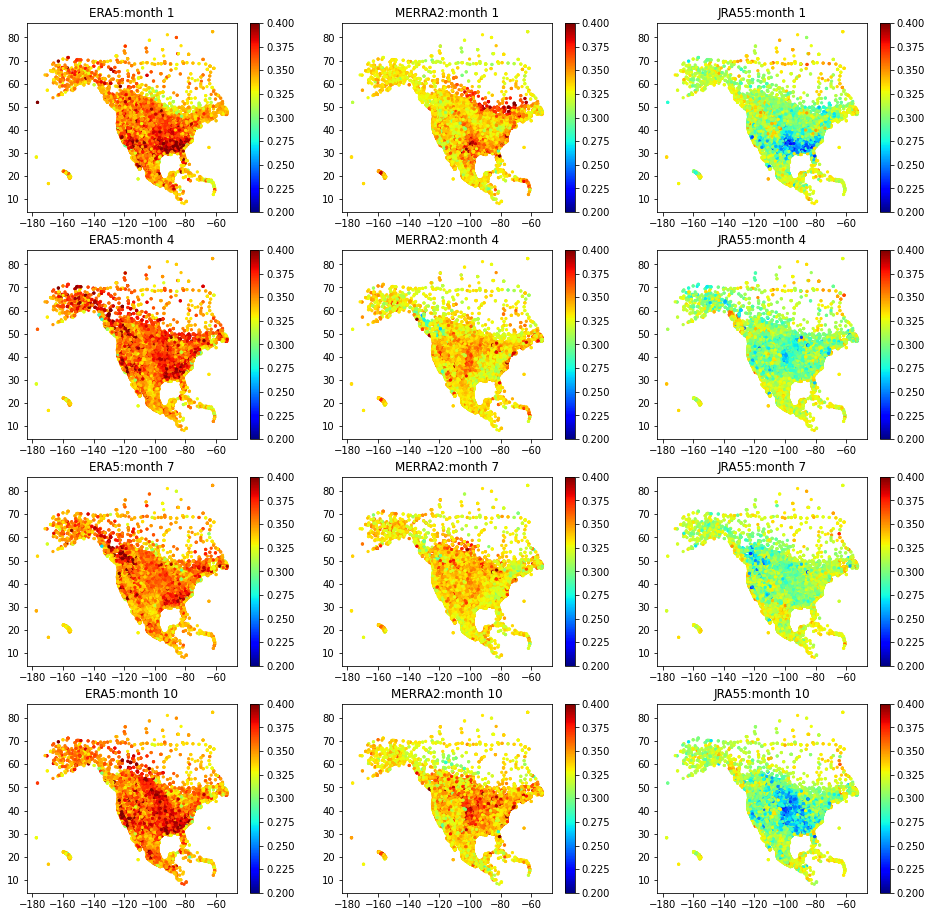

In [36]:
file_reamerge='/Users/localuser/Research/EMDNA/merge/mergecorr_stn_trange_GWRQM_BMA.npz'
d=np.load(file_reamerge)
reamerge_weight_stn=d['reamerge_weight_stn']

reaname=['ERA5','MERRA2','JRA55']
plt.figure(figsize=[16,16])
flag=1
for m in [0,3,6,9]:
    for i in range(3):
        plt.subplot(4,3,flag)
        plt.scatter(stn_lle[:,1],stn_lle[:,0],5,reamerge_weight_stn[m,:,i],cmap='jet')
        cbar = plt.colorbar()
        plt.clim([0.2,0.4])
        plt.title(reaname[i]+':month '+str(m+1))
        flag=flag+1